# Train, Deploy and Test a Machine Learning Model with SageMaker


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

## Install and Import Dependencies

In [3]:
!pip install smdebug torch torchvision

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [4]:
import os
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

## Dataset

The dataset used for this project is the dog breed dataset. It contains 133 different breeds of dogs. The dataset is split into a training set, a validation set and a test set. The training set contains 6680 images, the validation set contains 835 images and the test set contains 836 images. The images are of different sizes and are in color. The images are in the format of jpg. The dataset is available at [this link](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).

In [5]:
%%capture
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
!aws s3 cp dogImages s3://proj-3/ --recursive

### Global variables

In [6]:
BUCKET = 'proj-3'

os.environ['SM_CHANNEL_TRAINING']=f's3://{BUCKET}/'
os.environ['SM_MODEL_DIR']=f's3://{BUCKET}/model/'
os.environ['SM_OUTPUT_DATA_DIR']=f's3://{BUCKET}/output/'

data_channels = {
    "train": "s3://{}/train/".format(BUCKET),
    "test": "s3://{}/test/".format(BUCKET),
    "valid": "s3://{}/valid/".format(BUCKET)
}

role = sagemaker.get_execution_role()

## Hyperparameter Tuning

In [32]:
hyperparameter_ranges = {
    "learning-rate": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([16, 32, 64, 128, 256, 512]),
    "early-stopping-rounds": CategoricalParameter([10, 12, 15, 17, 20])
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: (\d+\.\d+)"}]

### Create estimator and hyperparameter tuner

In [42]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="HP",
    role=role,
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version="py3",
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

### Fit the tuner

In [43]:
tuner.fit({"training": f"s3://{BUCKET}/"})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230324-2105


..............................................................................................................................................................................................!


### Get the best estimators and the best hyperparameters

In [44]:
best_estimator = tuner.best_estimator()
print(best_estimator.hyperparameters())

hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')), \
                   "learning-rate": best_estimator.hyperparameters()['learning-rate'],
                   "early-stopping-rounds": int(best_estimator.hyperparameters()['early-stopping-rounds'].replace('"', ''))
                  }
hyperparameters


2023-03-24 21:21:58 Starting - Found matching resource for reuse
2023-03-24 21:21:58 Downloading - Downloading input data
2023-03-24 21:21:58 Training - Training image download completed. Training in progress.
2023-03-24 21:21:58 Uploading - Uploading generated training model
2023-03-24 21:21:58 Completed - Resource retained for reuse
{'_tuning_objective_metric': '"Test Loss"', 'batch-size': '"16"', 'early-stopping-rounds': '"12"', 'learning-rate': '0.0010000000000000002', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"HP-2023-03-24-21-05-54-062"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-840824336874/HP-2023-03-24-21-05-54-062/source/sourcedir.tar.gz"'}


{'batch-size': 16,
 'learning-rate': '0.0010000000000000002',
 'early-stopping-rounds': 12}

## Model Profiling and Debugging

In [109]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "100",
        "eval.save_interval": "10"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

In [135]:
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="MAIN",
    role=role,
    instance_count=2,
    instance_type="ml.g4dn.xlarge",
    framework_version="1.8.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)
estimator.fit({"training": f"s3://{BUCKET}/"})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: MAIN-2023-03-25-01-50-20-562


2023-03-25 01:50:21 Starting - Starting the training job...VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-03-25 01:51:47 Starting - Preparing the instances for training......
2023-03-25 01:52:47 Downloading - Downloading input data......
2023-03-25 01:53:47 Training - Downloading the training image...............
2023-03-25 01:56:09 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-25 01:56:15,368 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-25 01:56:15,396 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-25 01:56:15,399 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-25 01:56:15,644 sagemaker-training-toolkit IN

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

## Debugging Output

In [136]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
description

{'TrainingJobName': 'MAIN-2023-03-25-01-50-20-562',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:840824336874:training-job/MAIN-2023-03-25-01-50-20-562',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-840824336874/MAIN-2023-03-25-01-50-20-562/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch-size': '16',
  'early-stopping-rounds': '12',
  'learning-rate': '"0.0010000000000000002"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"MAIN-2023-03-25-01-50-20-562"',
  'sagemaker_program': '"train_model.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-840824336874/MAIN-2023-03-25-01-50-20-562/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.8.0-gpu-py3',
  'TrainingInputMode': 'File',
  'EnableSageMakerMetricsTimeSeries': True},
 'RoleArn': 'arn

In [137]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-03-25 02:30:29.426 ip-172-16-155-215.ec2.internal:8123 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-840824336874/MAIN-2023-03-25-01-50-20-562/debug-output
[2023-03-25 02:30:29.727 ip-172-16-155-215.ec2.internal:8123 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 4704 more expected)', IncompleteRead(0 bytes read, 4704 more expected)) while reading s3://sagemaker-us-east-1-840824336874/MAIN-2023-03-25-01-50-20-562/debug-output/index/000000000/000000000700_worker_0.json . Will retry now


In [138]:
trial.tensor_names()

['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [139]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

95

In [140]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

6

In [141]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    print(f"[INFO] Getting data in {len(steps)} steps")
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
        print(".", end="")
    return steps, vals

In [142]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(20, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

[INFO] Getting data in 95 steps
...............................................................................................loaded TRAIN data
[INFO] Getting data in 6 steps
......loaded EVAL data
completed TRAIN plot
completed EVAL plot


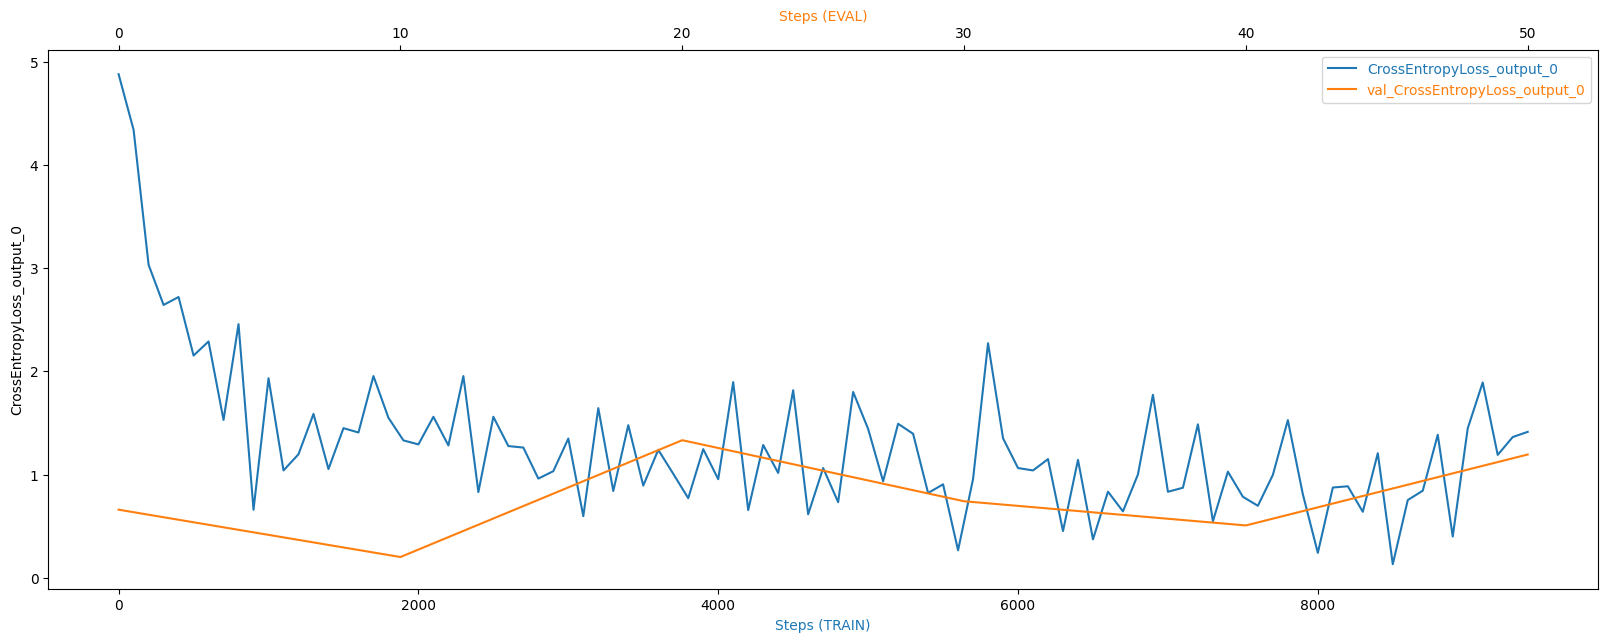

In [143]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

## PROFILER OUTPUT

In [144]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [145]:
! aws s3 ls {rule_output_path} --recursive

2023-03-25 02:30:10     490837 MAIN-2023-03-25-01-50-20-562/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-03-25 02:30:09     358631 MAIN-2023-03-25-01-50-20-562/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-03-25 02:30:03        918 MAIN-2023-03-25-01-50-20-562/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-03-25 02:30:03      21126 MAIN-2023-03-25-01-50-20-562/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-03-25 02:30:03       1824 MAIN-2023-03-25-01-50-20-562/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-03-25 02:30:03        327 MAIN-2023-03-25-01-50-20-562/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-03-25 02:30:03       1101 MAIN-2023-03-25-01-50-20-562/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
2023-03-25 02:30:03        545 MAIN-2023-03-25-01-50-20-562/

In [146]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-840824336874/MAIN-2023-03-25-01-50-20-562/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-840824336874/MAIN-2023-03-25-01-50-20-562/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-840824336874/MAIN-2023-03-25-01-50-20-562/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-840824336874/MAIN-2023-03-25-01-50-20-562/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-840824336874/MAIN-2023-03-25-01-50-20-562/rule-output/ProfilerReport/profiler-output/profil

In [147]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [148]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [155]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [160]:
pytorch_model = PyTorchModel(model_data=estimator.model_data, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [161]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker:Creating model with name: pytorch-inference-2023-03-25-02-44-17-222
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-03-25-02-44-17-853
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-03-25-02-44-17-853


------!

In [162]:
import requests
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

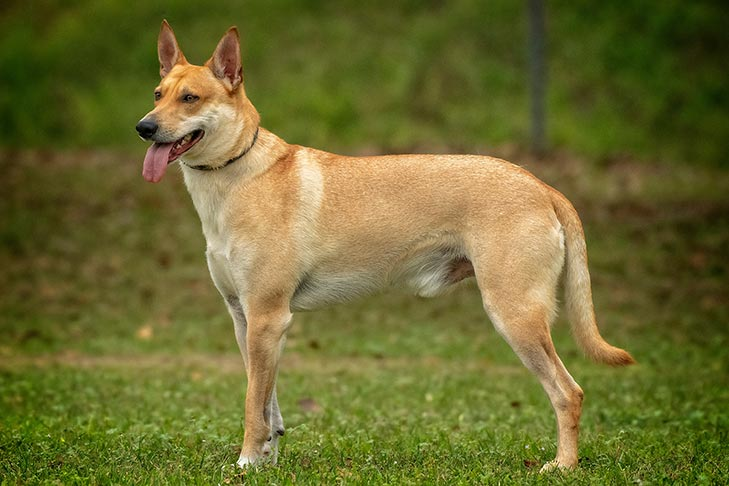

In [163]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [164]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [166]:
import numpy as np
np.argmax(response)

107

In [167]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-03-25-02-44-17-853
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-03-25-02-44-17-853
